C:\Users\Steve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Steve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


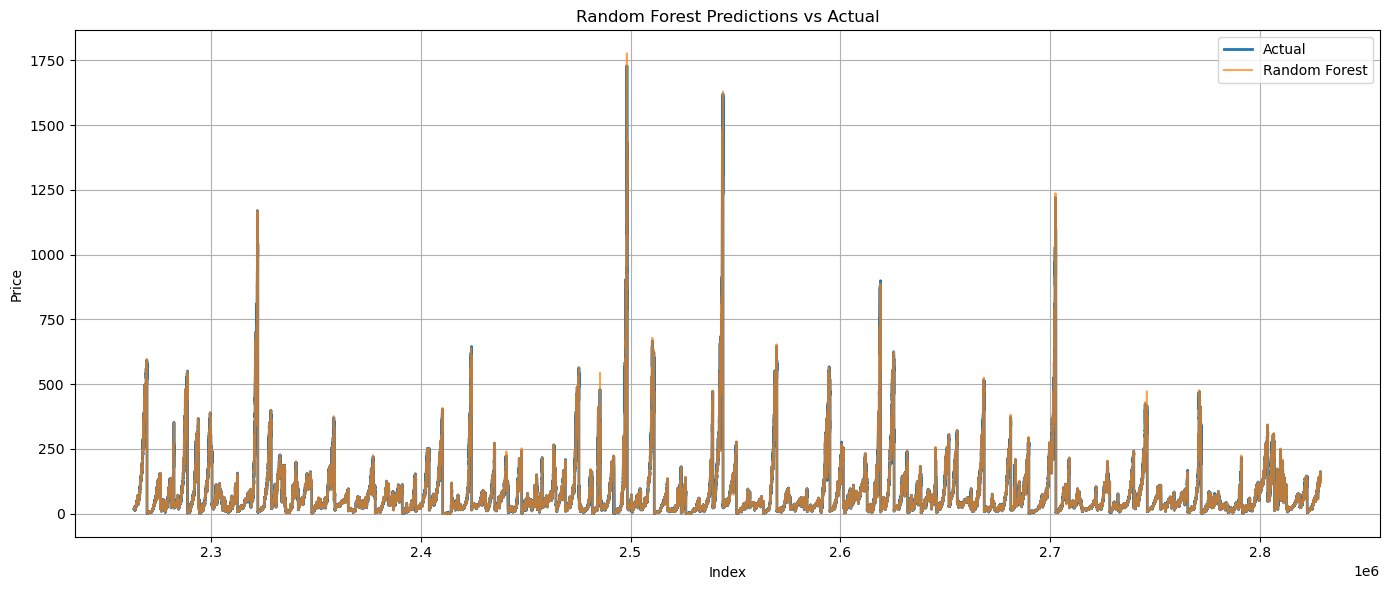

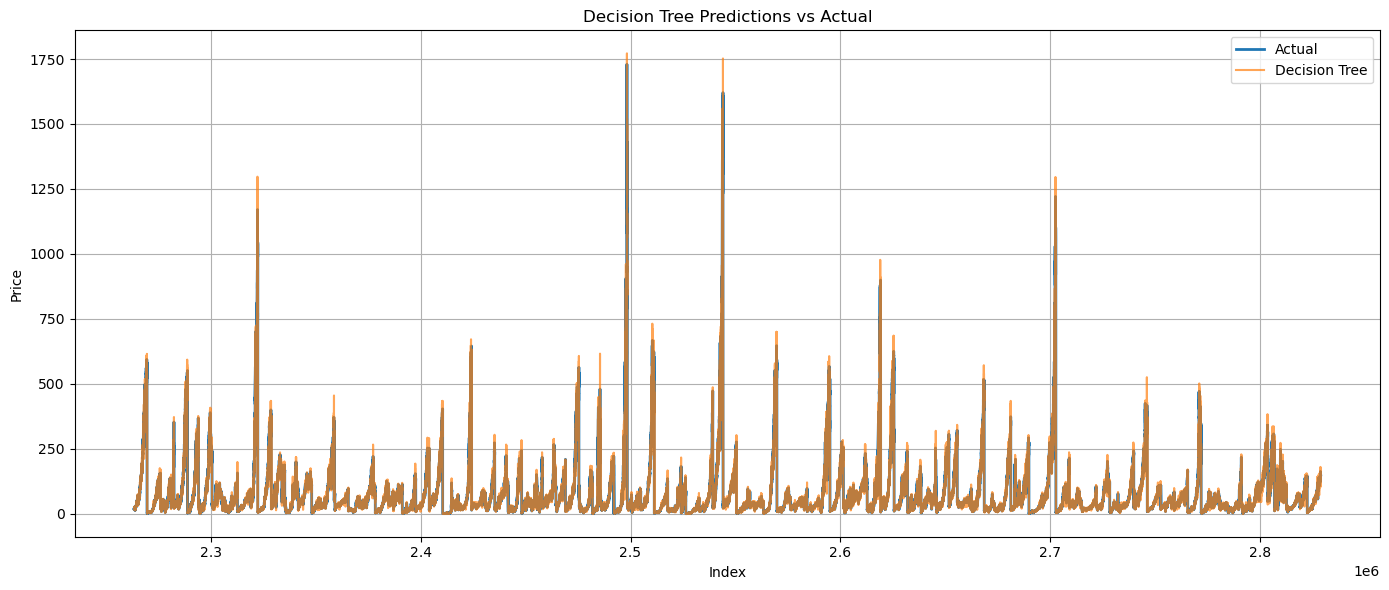

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Debugging help
NUM_COMPANIES = 500                   # Set to 500 for full run
FORCE_REDOWNLOAD = True               # Set to False if the spreadsheets are downloaded and current, stops the program from re-downloading the spreadsheets
SAVE_DIR = "data"
FUNDAMENTAL_DIR = "fundamentals"

# Get S&P tickers
def get_sp500_tickers():
    url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
    df = pd.read_csv(url)
    return df['Symbol'].str.replace('.', '-', regex=False).tolist()

# Download the data
def download_stock_data(tickers, start="2000-01-01", end=None, save_dir=SAVE_DIR, force_redownload=False):
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(FUNDAMENTAL_DIR, exist_ok=True)
    data = {}

    for i, ticker in enumerate(tickers):
        file_path = os.path.join(save_dir, f"{ticker}.csv")
        fundamentals_path = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")

        try:
            stock = yf.Ticker(ticker)
            if os.path.exists(file_path) and not force_redownload:
                print(f"Reading cached data for {ticker}")
                df = pd.read_csv(file_path)
                if 'Date' not in df.columns or 'Close' not in df.columns:
                    continue
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)
            else:
                print(f"Downloading {ticker} ({i+1}/{len(tickers)})")
                df = stock.history(start=start, end=end, auto_adjust=False)
                if df.empty or len(df) < 200:
                    continue
                df.reset_index(inplace=True)
                df.to_csv(file_path, index=False)
                df.set_index('Date', inplace=True)

            info = stock.info
            new_row = {
                'Date': datetime.today().strftime("%Y-%m-%d"),
                'Ticker': ticker,
                'peRatio': info.get('trailingPE', np.nan),
                'pegRatio': info.get('pegRatio', np.nan),
                'priceToSales': info.get('priceToSalesTrailing12Months', np.nan),
                'priceToBook': info.get('priceToBook', np.nan),
                'debtToEquity': info.get('debtToEquity', np.nan),
                'ebitda': info.get('ebitda', np.nan)
            }

            if os.path.exists(fundamentals_path):
                existing = pd.read_csv(fundamentals_path)
                if not ((existing['Date'] == new_row['Date']) & (existing['Ticker'] == new_row['Ticker'])).any():
                    updated = pd.concat([existing, pd.DataFrame([new_row])], ignore_index=True)
                    updated.to_csv(fundamentals_path, index=False)
            else:
                pd.DataFrame([new_row]).to_csv(fundamentals_path, index=False)

            df['Ticker'] = ticker
            data[ticker] = df
            time.sleep(0.2)

        except Exception as e:
            print(f"Error with {ticker}: {e}")

    return data

# Preprocess for training
def preprocess_data(data):
    frames = []
    for ticker, df in data.items():
        try:
            if 'Close' not in df.columns:
                raise ValueError(f"Missing Close column, shape: {df.shape}")

            df = df[['Open', 'High', 'Low', 'Volume', 'Close']].copy()
            df['Lag_Close'] = df['Close'].shift(1)
            df['Lag_1'] = df['Close'].shift(1)
            df['MA_5'] = df['Close'].rolling(5).mean()
            df['Return'] = df['Close'].pct_change()
            df['Target'] = df['Close'].shift(-5)
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            fund_file = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")
            if not os.path.exists(fund_file):
                continue

            row = pd.read_csv(fund_file).sort_values('Date').iloc[-1]
            for col in ['peRatio', 'pegRatio', 'priceToSales', 'priceToBook', 'debtToEquity', 'ebitda']:
                df[col] = row.get(col, np.nan)

            df['Ticker'] = ticker
            frames.append(df)

        except Exception as e:
            print(f"Preprocessing error on {ticker}: {e}")

    if not frames:
        raise ValueError("All tickers failed during preprocessing.")

    result = pd.concat(frames)
    result.reset_index(inplace=True)
    return result

# Extract features and labels
def prepare_features(df):
    y = df['Target']
    X = df.drop(columns=['Target'])
    non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns.tolist()
    for col in ['Date', 'Datetime']:
        if col in X.columns:
            non_numeric_cols.append(col)
    X.drop(columns=list(set(non_numeric_cols)), inplace=True)
    le = LabelEncoder()
    if 'Ticker' in df.columns:
        X['Ticker'] = le.fit_transform(df['Ticker'])
    return X, y

# Train and evaluate
def train_and_evaluate(X, y, model_name="RandomForest"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    if model_name == "RandomForest":
        model = RandomForestRegressor(n_estimators=100, random_state=1)
    elif model_name == "DecisionTree":
        model = DecisionTreeRegressor(random_state=1)
    else:
        raise ValueError("Unknown model")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    return model, X_test.index, y_test, preds, rmse, r2

# Plot predictions
def plot_predictions(index, y_true, rf_pred, dt_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(index, y_true, label='Actual', linewidth=2)
    plt.plot(index, rf_pred, label='Random Forest', alpha=0.7)
    plt.title("Random Forest Predictions vs Actual")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(index, y_true, label='Actual', linewidth=2)
    plt.plot(index, dt_pred, label='Decision Tree', alpha=0.7)
    plt.title("Decision Tree Predictions vs Actual")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot feature importances
def plot_feature_importances(model, X, title):
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Model does not support feature importances.")
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=np.array(X.columns)[indices])
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    return importances

# Main Prog
tickers = get_sp500_tickers()[:NUM_COMPANIES]
stock_data = download_stock_data(tickers, force_redownload=FORCE_REDOWNLOAD)
processed = preprocess_data(stock_data)
X, y = prepare_features(processed)

rf_model, rf_index, rf_y, rf_pred, rf_rmse, rf_r2 = train_and_evaluate(X, y, model_name="RandomForest")
dt_model, dt_index, dt_y, dt_pred, dt_rmse, dt_r2 = train_and_evaluate(X, y, model_name="DecisionTree")

plot_predictions(rf_index, rf_y, rf_pred, dt_pred)
rf_importances = plot_feature_importances(rf_model, X, "Random Forest Feature Importances")
dt_importances = plot_feature_importances(dt_model, X, "Decision Tree Feature Importances")

print(f"\nRandom Forest: RMSE = {rf_rmse:.2f}, R2 Score = {rf_r2:.4f}")
print(f"Decision Tree: RMSE = {dt_rmse:.2f}, R2 Score = {dt_r2:.4f}")
